Importing libraries necessary for data exploration and setting up file paths for the raw data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

path="data/"
sub={'production_meter/':['average_power(kw)/'], 'weather_station/':['temperature(f)/','irradiance(w_per_m2)/']}
med='15_minutes/'
fin=['12_23_2019-12_31_2019', '01_01_2020-01_31_2020','02_01_2020-02_29_2020','03_01_2020-03_31_2020','04_01_2020-04_30_2020','05_01_2020-05_31_2020','06_01_2020-06_30_2020','07_01_2020-07_31_2020','08_01_2020-08_31_2020','09_01_2020-09_30_2020','10_01_2020-10_31_2020','11_01_2020-11_30_2020','12_01_2020-12_26_2020']
end='.csv'

Importing the raw data files

In [2]:
csvs={}
for i in sub: #going through each source for the data
    for j in sub[i]: #going though each category in each source
        csvs[j]=pd.DataFrame()
        for k in fin: #going though each month available
            t=pd.read_csv(path+i+j+med+k+end, index_col='Site Time', parse_dates=['Site Time']) #reading a full path name for one csv file, with the timestamps read as datettime objects for the index
            csvs[j]=pd.concat([csvs[j], t])
power, temp, irradiance=csvs['average_power(kw)/'], csvs['temperature(f)/'], csvs['irradiance(w_per_m2)/']

Determining the amount of missing values for each category of data

In [3]:
print('Temperature: \n'+str(temp.isnull().sum())+'\n')
print('Irradiance: \n'+str(irradiance.isnull().sum())+'\n')
print('Power: \n'+str(power.isnull().sum())+'\n')

Temperature: 
Weather station module temperature                        2717
Weather station ambient temperature Degrees Fahrenheit    2717
Weather station device temperature                        2717
dtype: int64

Irradiance: 
POA Watts/meter²    2717
GHI Watts/meter²    2717
dtype: int64

Power: 
Production meter active power Kilowatts    2713
dtype: int64



Eliminating the rows with missing values

In [4]:
temp=temp.dropna()
irradiance=irradiance.dropna()
power=power.dropna()

Data is converted to numeric types

In [5]:
power['Production meter active power Kilowatts']=pd.to_numeric(power['Production meter active power Kilowatts'].astype(str).str.replace(',','')) #the issue is that some entries have commas, like 1,000, so first they are converted to strings, then the commas are removed before conversion to numbers
irradiance['POA Watts/meter²'], irradiance['GHI Watts/meter²']=pd.to_numeric(irradiance['POA Watts/meter²'].astype(str).str.replace(',','')), pd.to_numeric(irradiance['GHI Watts/meter²'].astype(str).str.replace(',',''))

Plotting the average hourly power output by month

In [10]:
months=np.zeros((12, 24)) #columns are the hour, rows are the month. Each cell represents the total power produced for that hour for that month
count=np.zeros((12, 24)) #same columns and rows. Each cell represents the number of data instances for that hour for that month
for index, row in power.iterrows(): #going through each row in the power file
    months[index.month-1, index.hour]+=row['Production meter active power Kilowatts'] #adding the power
    count[index.month-1][index.hour]+=1 #increasing the count
months=np.divide(months, count) #each cell now represents the average hourly power output after division by the cells in the array count

categories = [str(i)+':00' for i in reversed(range(24))] #creating the labels for the hours

fig = go.Figure()
m={0:'January', 1:'February', 2:'March', 3:'April', 4:'May', 5:'June', 6:'July', 7:'August', 8:'September', 9:'October', 10:'November', 11:'December'} #the labels for the months
for i in range(12):   
    fig.add_trace(go.Scatterpolar(
          r=list(reversed(months[i])), #each month is given
          theta=categories, #the hourly labels
          name=m[i] #the monthly labels
    ))
fig.update_layout(
    showlegend = True,
    polar = dict(
      radialaxis_tickfont_size = 20,
      angularaxis = dict(
        tickfont_size=20,
        rotation=90, 
        direction="counterclockwise"
      )
    ))

fig.update_polars(radialaxis_angle=90, radialaxis_ticksuffix=' kw') #adding units
fig.show()

Box plot of power production 

In [21]:
fig = px.box(power.between_time('7:0', '18:0'), x="Production meter active power Kilowatts") #box plot showing only daytime values
fig.update_layout(
    xaxis_title="Kilowatts",
)
fig.show()

Box plot of irradiance values

In [19]:
fig = go.Figure()
fig.add_trace(go.Box(x=irradiance.between_time('7:0', '18:0')['POA Watts/meter²'], name='Plane of irradiance'))
fig.add_trace(go.Box(x=irradiance.between_time('7:0', '18:0')['GHI Watts/meter²'], name='Global horizontal irradiance'))
fig.update_layout(
    xaxis_title="Watts per square meter",
)
fig.show()

Box plot of temperature values

In [23]:
fig = go.Figure()
fig.add_trace(go.Box(x=temp.between_time('7:0', '18:0')['Weather station module temperature '], name='Module temperature '))
fig.add_trace(go.Box(x=temp.between_time('7:0', '18:0')['Weather station ambient temperature Degrees Fahrenheit'], name='Ambient temperature'))
fig.add_trace(go.Box(x=temp['Weather station device temperature '].between_time('7:0', '18:0'), name='Device temperature '))
fig.update_layout(
    xaxis_title="Fahrenheit",
)
fig.show()

Finding the error values

In [37]:
temp[temp['Weather station device temperature ']<0] #the anomalous values

Weather station module temperature   \
Site Time                                                  
2020-01-15 11:15:00                               61.292   
2020-01-15 12:45:00                               74.608   
2020-01-15 13:15:00                               70.321   
2020-03-11 12:00:00                               76.031   
2020-03-30 22:00:00                               40.799   
2020-08-10 11:30:00                              133.938   
2020-09-30 00:30:00                               70.683   

                     Weather station ambient temperature Degrees Fahrenheit  \
Site Time                                                                     
2020-01-15 11:15:00                                             45.605        
2020-01-15 12:45:00                                             48.770        
2020-01-15 13:15:00                                             49.354        
2020-03-11 12:00:00                                             51.695        
2020-03-30 22:00:00                                             42.376        
2020-08-10 11:30:00                                             90.381        
2020-09-30 00:30:00                                             72.295        

                     Weather station device temperature   
Site Time                                                 
2020-01-15 11:15:00                               -384.7  
2020-01-15 12:45:00                               -654.7  
2020-01-15 13:15:00                               -131.8  
2020-03-11 12:00:00                               -366.7  
2020-03-30 22:00:00                                -74.2  
2020-08-10 11:30:00                                -80.5  
2020-09-30 00:30:00                               -535.9

Histograms of each data category

In [27]:
fig = make_subplots(rows=3, cols=2)

trace0 = go.Histogram(x=power['Production meter active power Kilowatts'].between_time('7:0','18:0'), nbinsx=20, name='Power output')
trace1 = go.Histogram(x=temp['Weather station module temperature '].between_time('7:0','18:0'), nbinsx = 20, name='Module temp')
trace4 = go.Histogram(x=temp['Weather station device temperature '].between_time('7:0','18:0'), nbinsx = 20, name='Device temp')
trace5 = go.Histogram(x=temp['Weather station ambient temperature Degrees Fahrenheit'].between_time('7:0','18:0'), nbinsx = 20, name='Ambient temp')
trace2 = go.Histogram(x=irradiance['POA Watts/meter²'].between_time('7:0','18:0'), nbinsx=20, name='Plane of array')
trace3 = go.Histogram(x=irradiance['GHI Watts/meter²'].between_time('7:0','18:0'), nbinsx=20, name='Global horizontal irradiance')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)
fig.append_trace(trace4, 3, 1)
fig.append_trace(trace5, 3, 2)

fig.show()

Merging all data into one DataFrame

In [28]:
site_data=power.merge(temp, on='Site Time').merge(irradiance, on='Site Time')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32807 entries, 2019-12-23 08:00:00 to 2020-12-26 23:45:00
Data columns (total 6 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Production meter active power Kilowatts                 32807 non-null  float64
 1   Weather station module temperature                      32807 non-null  float64
 2   Weather station ambient temperature Degrees Fahrenheit  32807 non-null  float64
 3   Weather station device temperature                      32807 non-null  float64
 4   POA Watts/meter²                                        32807 non-null  float64
 5   GHI Watts/meter²                                        32807 non-null  float64
dtypes: float64(6)
memory usage: 1.8 MB


Heatmap showing correlations of each variable against each other one

<AxesSubplot:>

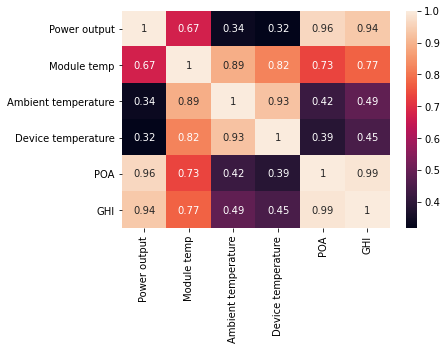

In [36]:
site_data=site_data.rename(columns={'Production meter active power Kilowatts':'Power output', 'Weather station module temperature ':'Module temp','Weather station ambient temperature Degrees Fahrenheit':'Ambient temperature','POA Watts/meter²':'POA', 'GHI Watts/meter²':'GHI','Weather station device temperature ':'Device temperature'})

sns.heatmap(site_data.between_time('7:0','18:0').corr(), annot = True) #only daytime values